In [1]:
import configparser

In [2]:
import os.path as op

In [3]:
CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
CP.sections()
ak = CP.get('default', 'AWS_ACCESS_KEY_ID')
sk = CP.get('default', 'AWS_SECRET_ACCESS_KEY')

In [4]:
import numpy as np
import cottoncandy as cc

In [5]:
from tempfile import mkdtemp
import os.path as path

In [6]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching
from imp import reload
reload(alpenglow.stitching)
from alpenglow.stitching import stitch, find_shift, apply_shift, stitch_zstack
import alpenglow.stitching as ast

In [7]:
import skimage
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
import skimage.external.tifffile as tif

In [8]:
import dask.array as da
from dask import delayed

In [9]:
import time

In [10]:
file_list = ['/phantom_2_7_2017/%06d/%06d_%05d.tif'%(s, s, i) for s in range(3) for i in range(1, 1801) ]

In [11]:
from io import BytesIO

In [12]:
f = file_list[0]

In [13]:
import tempfile

In [14]:
cci = cc.get_interface('alpenglowoptics', 
                       ACCESS_KEY=ak, 
                       SECRET_KEY=sk,
                       endpoint_url='https://s3.amazonaws.com')

Available buckets:
aamirdsbucket                            2015/06/24 (10:07:20)
airlineeconomics                         2015/01/28 (19:34:11)
alpenglowoptics                          2017/01/11 (00:43:32)
arokem-mribmarktmp                       2016/03/31 (00:54:20)
arxiv-compressed                         2015/05/16 (00:05:05)
arxiv-tars                               2015/05/15 (20:32:23)
arxiv-tars-pdfs                          2015/05/15 (23:27:25)
aws-logs-455598791984-us-east-1          2015/06/24 (09:27:48)
bernease                                 2016/01/28 (18:33:44)
bijaybuc                                 2015/06/24 (11:50:12)
census-cdr                               2016/07/08 (23:30:03)
cf-templates-khq1qvxd59lq-us-east-1      2012/10/24 (18:27:30)
community-wellbeing                      2015/06/25 (18:36:25)
dssgparatransitdata                      2016/08/29 (21:49:24)
elasticbeanstalk-us-east-1-455598791984  2016/09/15 (01:11:14)
escience-cloud-trail                

In [15]:
def s3_to_memmap(f, cci):
    o = cci.download_object(f)
    b = BytesIO(o)
    t = tif.TiffFile(b)
    a = t.asarray()
    mm_file = tempfile.TemporaryFile()
    mm = np.memmap(mm_file, dtype=a.dtype, 
                   shape=a.shape)
    mm_file.close()
    mm[:] = a
    return mm
  

In [16]:
sample = s3_to_memmap(file_list[0], cci)

In [17]:
cat_arr = np.concatenate([s3_to_memmap(fname, cci) for fname in file_list[:100]])

In [19]:
cat_arr.shape

(51200, 900)

In [20]:
imread = delayed(s3_to_memmap, pure=True) 

In [21]:
lazy_values = [imread(filename, cci) for filename in file_list[:1800]]

In [22]:
arrays = [da.from_delayed(lazy_value,           # Construct a small Dask array
                          dtype=sample.dtype,   # for every lazy value
                          shape=sample.shape)
          for lazy_value in lazy_values]


In [23]:
stack = da.stack(arrays, axis=0)

In [24]:
stack

dask.array<stack-8..., shape=(1800, 512, 900), dtype=uint16, chunksize=(1, 512, 900)>

In [25]:
skimage.io.imshow(stack[:,100,:].compute())

OSError: [Errno 24] Too many open files

Traceback
---------
  File "/opt/anaconda/lib/python3.5/site-packages/dask/async.py", line 268, in execute_task
  File "/opt/anaconda/lib/python3.5/site-packages/dask/async.py", line 248, in _execute_task
  File "/opt/anaconda/lib/python3.5/site-packages/dask/async.py", line 248, in <listcomp>
  File "/opt/anaconda/lib/python3.5/site-packages/dask/async.py", line 249, in _execute_task
  File "<ipython-input-17-aed8d02b5680>", line 8, in s3_to_memmap
    shape=a.shape)
  File "/opt/anaconda/lib/python3.5/site-packages/numpy/core/memmap.py", line 260, in __new__


In [96]:
%%timeit
arr0 = s3_to_memmap(file_list[0])

10 loops, best of 3: 34.7 ms per loop


In [98]:
20000 * 35 / 1000

700.0

In [92]:
for fname in file_list: 
    s3_to_memmap(fname)

KeyboardInterrupt: 

In [93]:
fname

'/phantom_2_7_2017/000000/000000_00351.tif'

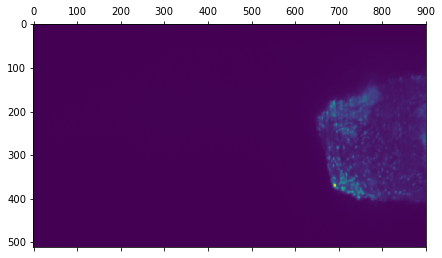

In [45]:
plt.matshow(a)

In [ ]:
images_7 = imread_collection("../data/im_000007_0*")
images_8 = imread_collection("../data/im_000008_0*")
images_9 = imread_collection("../data/im_000009_0*")

In [ ]:
def collection_to_memmap(collection):
    f = path.join(mkdtemp(), 'images7.dat')
    h = open(f, 'w')
    mm = np.memmap(f, dtype=collection[0].dtype, 
                   shape=(len(collection), 
                          collection[0].shape[0], 
                          collection[0].shape[1]))
    for z in range(mm.shape[0]):
        mm[z] = collection[z]
    
    return mm

In [ ]:
t1 = time.time()
mm7 = collection_to_memmap(images_7)
mm8 = collection_to_memmap(images_8)
t2 = time.time()
print(t2-t1)

In [ ]:
t1 = time.time()
stack_8_mm = ast.stitch_zstack(mm7, mm8)
t2 = time.time()
print(t2-t1)

In [ ]:
t1 = time.time()
stack_8_col = ast.stitch_zstack(images_7, images_8, current_stack=8)
t2 = time.time()
print(t2-t1)

In [ ]:
226 + 80, 510

In [ ]:
plt.matshow(stack_8_col[1][:, 10000:15000])

In [ ]:
plt.matshow(stack_8_mm[1, :, 10000:15000])

In [ ]:
np.all(stack_8_col[1] == stack_8_mm[1])

In [ ]:
f = np.fft.fft2(stack_8_mm[1, :, 10000:15000])

In [ ]:
plt.matshow(np.log(np.fft.fftshift(np.abs(f))))

In [ ]:
f_shift = np.fft.fftshift(f)

In [ ]:
f_shift[723-10:723+10, 800:1000] = np.mean(f_shift)
f_shift[723-10:723+10, -1000:-800] = np.mean(f_shift)

In [ ]:
plt.matshow(np.log(np.abs(f_shift)))

In [ ]:
plt.plot(np.log(f_shift)[723])
plt.plot([800, 800], [0, 22])
plt.plot([1000, 1000], [0, 22])

In [ ]:
plt.matshow(np.abs(np.fft.ifft2(np.fft.fftshift(f_shift))), cmap='viridis')